In [1]:
import tensorflow as tf

# List of GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("Name:", gpu.name, "Type:", gpu.device_type)
else:
    print("No GPU devices found.")

Name: /physical_device:GPU:0 Type: GPU


In [2]:
import numpy as np

# Load the .npy file
training_medseg = np.load('D:/Anik/NewData/covid-segmentation/images_medseg.npy')

# Print the size of the array
print(f'Size of the array: {training_medseg.size}')

# Print the shape of the array
print(f'Shape of the array: {training_medseg.shape}')


Size of the array: 26214400
Shape of the array: (100, 512, 512, 1)


In [3]:
training_mask_medseg = np.load('D:/Anik/NewData/covid-segmentation/masks_medseg.npy')

# Print the size of the array
print(f'Size of the array: {training_mask_medseg.size}')

# Print the shape of the array
print(f'Shape of the array: {training_mask_medseg.shape}')


Size of the array: 104857600
Shape of the array: (100, 512, 512, 4)


In [4]:
import numpy as np
#import numpy as np

# Load training images and masks from the Medseg part
images_medseg = np.load('D:/Anik/NewData/covid-segmentation/images_medseg.npy')
masks_medseg = np.load('D:/Anik/NewData/covid-segmentation/masks_medseg.npy')

# Load test images from the Medseg part
test_images_medseg = np.load('D:/Anik/NewData/covid-segmentation/test_images_medseg.npy')

# Load training images and masks from the Radiopedia part
images_radiopedia = np.load('D:/Anik/NewData/covid-segmentation/images_radiopedia.npy')
masks_radiopedia = np.load('D:/Anik/NewData/covid-segmentation/masks_radiopedia.npy')

images_radiopedia = images_radiopedia[4:571]
masks_radiopedia  = masks_radiopedia[4:571]


In [5]:
print(images_radiopedia.shape)
print(masks_radiopedia.shape)

(567, 512, 512, 1)
(567, 512, 512, 4)


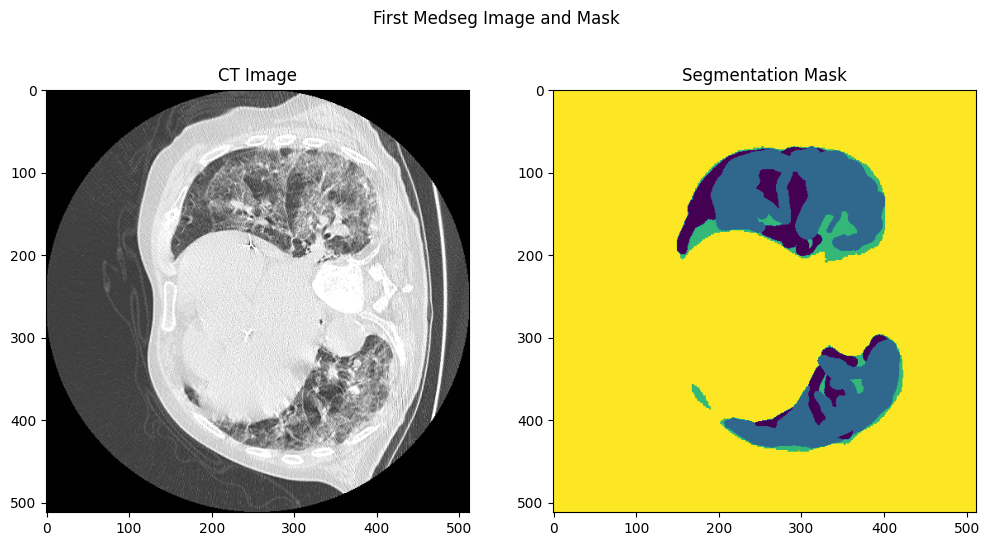

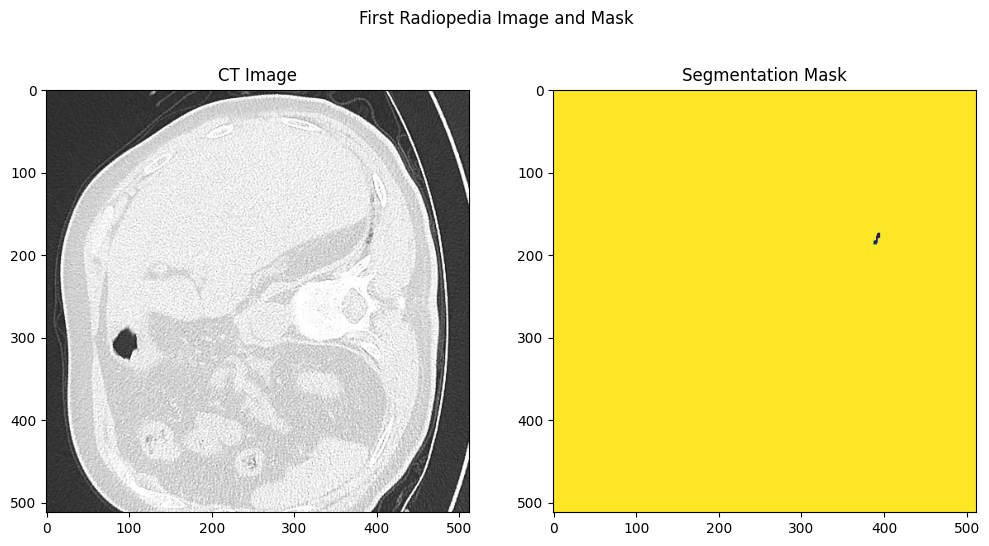

In [6]:
import matplotlib.pyplot as plt

def visualize_image_and_mask(image, mask, title='Image and Mask'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('CT Image')
    
    # Assuming the mask is one-hot encoded with 4 channels, we convert it to a single label mask.
    # Each pixel is assigned the label of the channel with the highest value.
    mask_label = np.argmax(mask, axis=-1)
    
    ax[1].imshow(mask_label, cmap='viridis')
    ax[1].set_title('Segmentation Mask')
    
    plt.suptitle(title)
    plt.show()

# Visualize the first image and mask from the Medseg part
visualize_image_and_mask(images_medseg[0], masks_medseg[0], 'First Medseg Image and Mask')

# Visualize the first image and mask from the Radiopedia part
visualize_image_and_mask(images_radiopedia[0], masks_radiopedia[0], 'First Radiopedia Image and Mask')


In [7]:
combined_images = np.concatenate((images_medseg, images_radiopedia), axis=0)
combined_masks = np.concatenate((masks_medseg, masks_radiopedia), axis=0)


In [8]:
print(combined_images.shape)
print(combined_masks.shape)

(667, 512, 512, 1)
(667, 512, 512, 4)


In [9]:
combined_masks[0]

array([[[False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]],

       [[False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]],

       [[False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]],

       ...,

       [[False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]],

       [[False,

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define the data generators for augmentation
img_gen_args = dict(      # Random rotations
    width_shift_range=0.1,  # Random shifts
    height_shift_range=0.1, 
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Horizontal flips
    vertical_flip=True,     # Vertical flips  
    fill_mode='reflect',     # Fill in new pixels after a shift,
    rescale=1./255,

)

mask_gen_args = dict(      # Random rotations
    width_shift_range=0.1,  # Random shifts
    height_shift_range=0.1, 
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Horizontal flips
    vertical_flip=True,     # Vertical flips  
    fill_mode='reflect',     # Fill in new pixels after a shift,
)

# Note: For random elastic deformations, you will need to implement a custom function
# or use a library that supports this kind of augmentation.

image_datagen = ImageDataGenerator(**img_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 42

from sklearn.model_selection import train_test_split

# Split data into train and test+validation set
train_images, test_val_images, train_masks, test_val_masks = train_test_split(
    combined_images, combined_masks, test_size=0.3, random_state=seed)  # 70% training, 30% test+validation

# Split test+validation set into test and validation sets
test_images, val_images, test_masks, val_masks = train_test_split(
    test_val_images, test_val_masks, test_size=0.5, random_state=seed)  # Split the 30% into 15% test and 15% validation


image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_masks, augment=True, seed=seed)

train_image_generator = image_datagen.flow(
    train_images, batch_size=1, shuffle=True, seed=seed)

train_mask_generator = mask_datagen.flow(
    train_masks, batch_size=1, shuffle=True, seed=seed)

val_image_generator = image_datagen.flow(
    val_images, batch_size=1, shuffle=True, seed=seed)

val_mask_generator = mask_datagen.flow(
    val_masks, batch_size=1, shuffle=True, seed=seed)

test_image_generator = image_datagen.flow(
    test_images, batch_size=1, shuffle=False, seed=seed)  # Typically no shuffle for testing

test_mask_generator = mask_datagen.flow(
    test_masks, batch_size=1, shuffle=False, seed=seed)


# Combine generators into one which yields image and masks


In [11]:
len(train_images)

466

In [12]:
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)


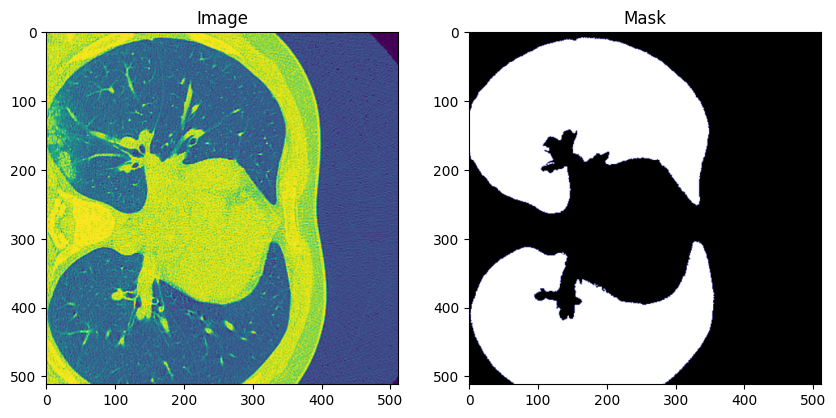

In [13]:
# Fetch a batch of images and masks
images_batch = next(train_image_generator)
masks_batch = next(train_mask_generator)

# Check the first pair as an example
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images_batch[0])
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(masks_batch[0], cmap='viridis')
plt.title('Mask')
plt.show()


In [14]:
masks_batch[0]

array([[[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       ...,

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0.

(512, 512)
[0 1 2 3]


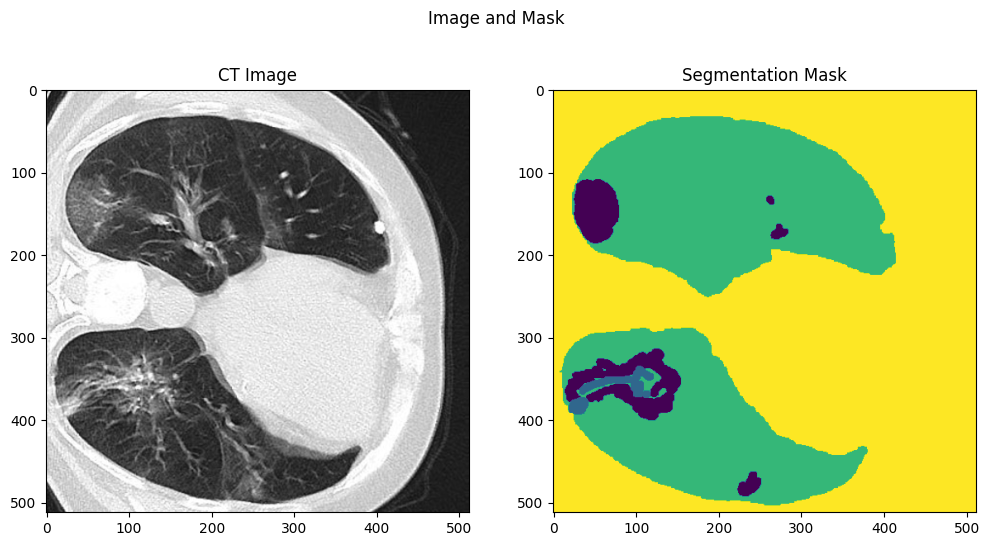

(512, 512)


In [15]:
sample_img,sample_mask = next(train_generator)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Plot the mask
ax[0].imshow(sample_img[0], cmap='gray')
ax[0].set_title('CT Image')

sample_mask = np.argmax(sample_mask[0],axis=-1)
print(sample_mask.shape)
print(np.unique(sample_mask))

ax[1].imshow(sample_mask, cmap='viridis')  # Change [0] based on the class you want to visualize
ax[1].set_title('Segmentation Mask')

plt.suptitle('Image and Mask')
plt.show()

print(sample_mask.shape)

In [16]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Softmax
from tensorflow.keras.models import Model

def unet(input_size=(512, 512, 1), num_classes=4):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    Conv2 = Conv2D(128, 3, activation='relu',padding='same')(pool1)
    Conv2 = Conv2D(128, 3, activation='relu',padding='same')(Conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(Conv2)

    Conv3 = Conv2D(256, 3, activation='relu',padding='same')(pool2)
    Conv3 = Conv2D(256, 3, activation='relu',padding='same')(Conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(Conv3)

    Conv4 = Conv2D(512,3, activation='relu',padding='same')(pool3)
    Conv4 = Conv2D(512,3, activation='relu',padding='same')(Conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(Conv4)

    Conv5 = Conv2D(1024,3, activation='relu',padding='same')(pool4)
    Conv5 = Conv2D(1024,3, activation='relu',padding='same')(Conv5)
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(Conv5)
    
    merge6 = concatenate([Conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([Conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([Conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    output = Conv2D(num_classes, 1,activation='softmax')(conv9)  # No activation here
    #output = Softmax(axis=-1)(conv10)      # Apply softmax along the channel axis


    model = Model(inputs=inputs, outputs=output)
    model.summary()
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 1)
    model = unet(input_shape,4)
    model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [17]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape, num_classes=4):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(num_classes, 1,activation='softmax')(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 1)
    model = attention_unet(input_shape)
    model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 alization)                     )                                                    

In [18]:
import tensorflow.keras.backend as K

def mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * K.round(y_pred)))
    union = K.sum(y_true) + K.sum(K.round(y_pred)) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

In [19]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.0  # Small constant to avoid division by zero
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [20]:
from tensorflow.keras.optimizers import SGD

optimize = SGD(learning_rate=0.001, momentum=0.99)

#optimize = Adam(learning_rate=0.001)


In [21]:
input_shape = (512, 512, 1)
model = attention_unet(input_shape)
model.compile(optimizer=optimize, loss='categorical_crossentropy', metrics=['accuracy',mean_iou])



In [22]:
model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 512, 512, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 512, 512, 64  256        ['conv2d_43[0][0]']              
 ormalization)                  )                                                    

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images),
    validation_data=val_generator,
    validation_steps=len(val_images),
    epochs=50
)

Epoch 1/50
466/466 [==============================] - 202s 387ms/step - loss: 0.1308 - accuracy: 0.8871 - mean_iou: 0.8128 - val_loss: 0.1914 - val_accuracy: 0.8085 - val_mean_iou: 0.7002
Epoch 2/50
466/466 [==============================] - 168s 361ms/step - loss: 0.0538 - accuracy: 0.9477 - mean_iou: 0.9072 - val_loss: 0.0400 - val_accuracy: 0.9620 - val_mean_iou: 0.9301
Epoch 3/50
466/466 [==============================] - 168s 361ms/step - loss: 0.0401 - accuracy: 0.9611 - mean_iou: 0.9291 - val_loss: 0.0459 - val_accuracy: 0.9555 - val_mean_iou: 0.9198
Epoch 4/50
466/466 [==============================] - 167s 359ms/step - loss: 0.0351 - accuracy: 0.9660 - mean_iou: 0.9375 - val_loss: 0.0402 - val_accuracy: 0.9626 - val_mean_iou: 0.9311
Epoch 5/50
466/466 [==============================] - 168s 360ms/step - loss: 0.0327 - accuracy: 0.9684 - mean_iou: 0.9417 - val_loss: 0.0660 - val_accuracy: 0.9365 - val_mean_iou: 0.8858
Epoch 6/50
466/466 [==============================] - 167s 3

In [24]:
model.save("50_Epoch_SGD_DiceLoss.h5")

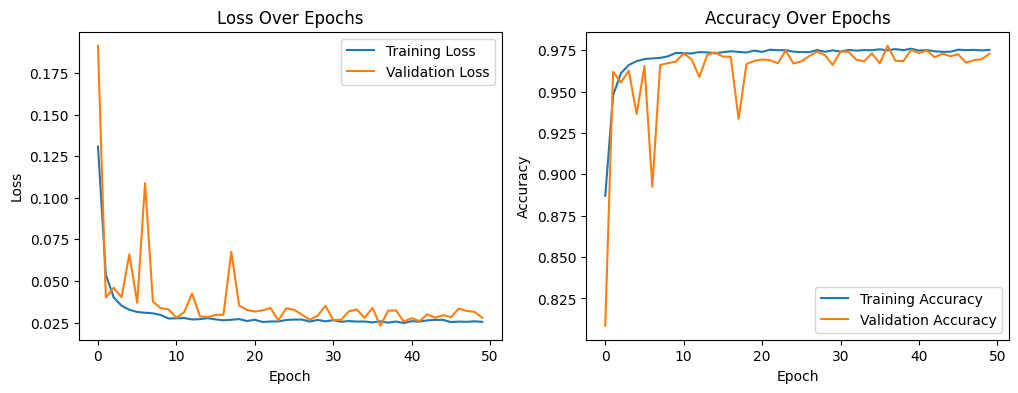

In [25]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call to plot the history
plot_history(history)

1/1 [==============================] - 0s 23ms/step


[]

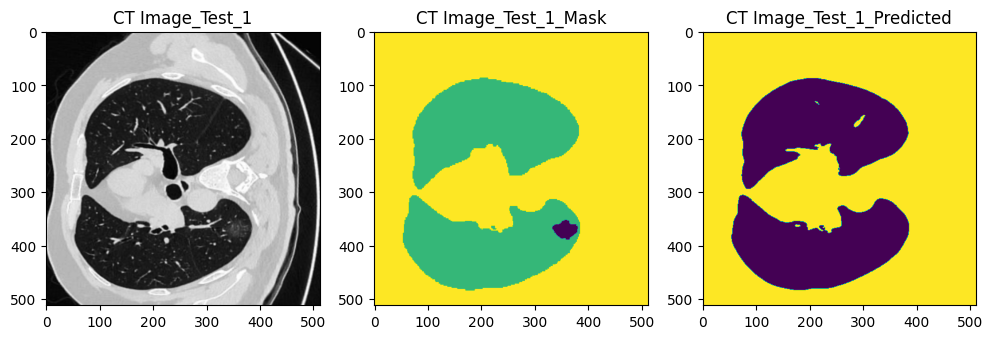

In [46]:
sample_test, sample_mask = next(test_generator)
ig, ax = plt.subplots(1, 3, figsize=(12, 6))
# Plot the mask
ax[0].imshow(sample_test[0], cmap='gray')
ax[0].set_title('CT Image_Test_1')

ax[1].imshow(np.argmax(sample_mask[0],axis=-1), cmap='viridis')
ax[1].set_title('CT Image_Test_1_Mask')

prediction = model.predict(sample_test)

predicted_image = np.argmax(prediction,axis=-1)[0]
#ig, ax = plt.subplots(1, 1, figsize=(12, 6))
# Plot the mask
ax[2].imshow(predicted_image, cmap='viridis')
ax[2].set_title('CT Image_Test_1_Predicted')


# plt.title("Test Mask and Predictions")
plt.plot()


In [47]:
input_shape = (512, 512, 1)
model.compile(optimizer=optimize, loss='categorical_crossentropy', metrics=['accuracy',mean_iou])


In [48]:
history1 = model.fit(
    train_generator,
    steps_per_epoch=len(train_images),
    validation_data=val_generator,
    validation_steps=len(val_images),
    epochs=30
)

Epoch 1/30
466/466 [==============================] - 202s 430ms/step - loss: 0.1629 - accuracy: 0.9557 - mean_iou: 0.9197 - val_loss: 0.1302 - val_accuracy: 0.9564 - val_mean_iou: 0.9244
Epoch 2/30
466/466 [==============================] - 180s 387ms/step - loss: 0.0948 - accuracy: 0.9694 - mean_iou: 0.9437 - val_loss: 0.2581 - val_accuracy: 0.9205 - val_mean_iou: 0.8627
Epoch 3/30
466/466 [==============================] - 167s 359ms/step - loss: 0.0746 - accuracy: 0.9750 - mean_iou: 0.9543 - val_loss: 0.2494 - val_accuracy: 0.9103 - val_mean_iou: 0.8457
Epoch 4/30
466/466 [==============================] - 168s 360ms/step - loss: 0.0672 - accuracy: 0.9783 - mean_iou: 0.9589 - val_loss: 0.0744 - val_accuracy: 0.9759 - val_mean_iou: 0.9547
Epoch 5/30
466/466 [==============================] - 168s 361ms/step - loss: 0.0549 - accuracy: 0.9818 - mean_iou: 0.9651 - val_loss: 0.0917 - val_accuracy: 0.9694 - val_mean_iou: 0.9429
Epoch 6/30
466/466 [==============================] - 169s 3

In [49]:
model.save("80_Epoch_SGD_AttentionUnet.h5")

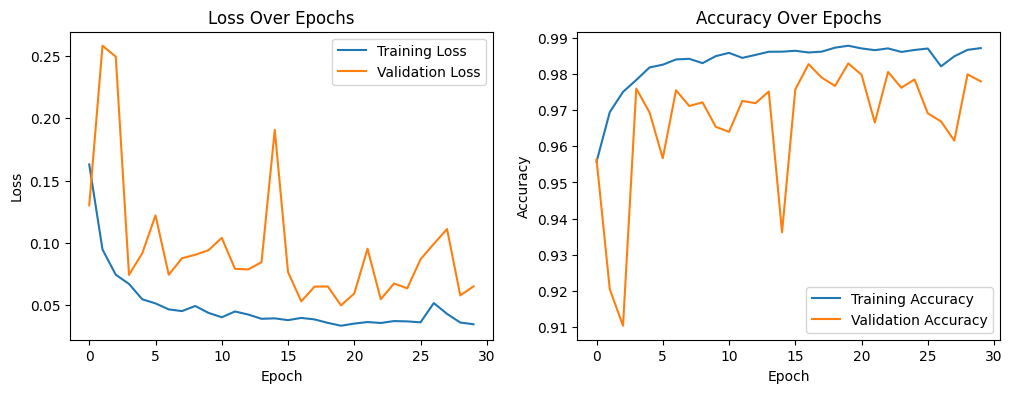

In [57]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call to plot the history
plot_history(history1)

1/1 [==============================] - 0s 22ms/step


[]

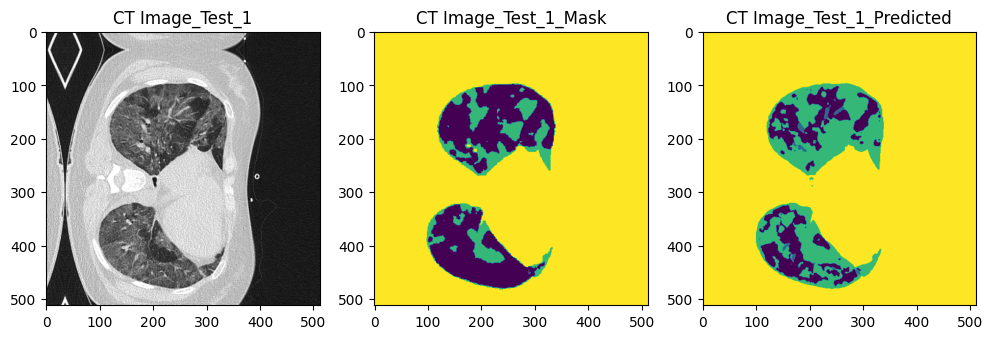

In [77]:
sample_test, sample_mask = next(test_generator)
ig, ax = plt.subplots(1, 3, figsize=(12, 6))
# Plot the mask
ax[0].imshow(sample_test[0], cmap='gray')
ax[0].set_title('CT Image_Test_1')

ax[1].imshow(np.argmax(sample_mask[0],axis=-1), cmap='viridis')
ax[1].set_title('CT Image_Test_1_Mask')

prediction = model.predict(sample_test)

predicted_image = np.argmax(prediction,axis=-1)[0]
#ig, ax = plt.subplots(1, 1, figsize=(12, 6))
# Plot the mask
ax[2].imshow(predicted_image, cmap='viridis')
ax[2].set_title('CT Image_Test_1_Predicted')


# plt.title("Test Mask and Predictions")
plt.plot()

Using a Custom Loss Function -> FoculCrossEntropy

In [106]:
import tensorflow as tf

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = self.alpha * tf.pow(1 - y_pred, self.gamma) * cross_entropy
        return tf.reduce_mean(loss)


In [129]:
class TverskyLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=0.5):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def call(self, y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        tp = tf.reduce_sum(y_true * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)

        tversky_coef = (tp + epsilon) / (tp + self.alpha * fn + self.beta * fp + epsilon)
        return 1 - tversky_coef


In [130]:
class CombinedFocalTverskyLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=0.5, gamma=2.0, focal_alpha=4.0):
        super(CombinedFocalTverskyLoss, self).__init__()
        self.tversky_loss = TverskyLoss(alpha, beta)
        #self.focal_loss = FocalLoss(gamma, focal_alpha)

    def call(self, y_true, y_pred):
        tversky = self.tversky_loss(y_true, y_pred)
        #focal = self.focal_loss(y_true, y_pred)
        return  (tversky )


In [131]:
# initial_learning_rate = 0.1
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     alpha=0.0)

# optimize = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [160]:
import tensorflow as tf

# Define the custom loss class/function if it's used in the model
class FocalCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, from_logits=False):
        super(FocalCrossEntropy, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = self.alpha * tf.pow(1 - y_pred, self.gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))



In [159]:
model = tf.keras.models.load_model('80_Epoch_SGD_AttentionUnet.h5', custom_objects={'FocalCrossEntropy': FocalCrossEntropy(),'mean_iou':mean_iou})

In [161]:
from tensorflow.keras.optimizers import SGD
optimize = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimize, loss=FocalCrossEntropy(), metrics=['accuracy',mean_iou])

In [162]:
history2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_images),
    validation_data=val_generator,
    validation_steps=len(val_images),
    epochs=20
)

Epoch 1/20
466/466 [==============================] - 188s 400ms/step - loss: 0.0042 - accuracy: 0.9880 - mean_iou: 0.9762 - val_loss: 0.0059 - val_accuracy: 0.9834 - val_mean_iou: 0.9671
Epoch 2/20
466/466 [==============================] - 169s 362ms/step - loss: 0.0036 - accuracy: 0.9884 - mean_iou: 0.9767 - val_loss: 0.0067 - val_accuracy: 0.9822 - val_mean_iou: 0.9650
Epoch 3/20
466/466 [==============================] - 168s 361ms/step - loss: 0.0035 - accuracy: 0.9884 - mean_iou: 0.9768 - val_loss: 0.0091 - val_accuracy: 0.9761 - val_mean_iou: 0.9540
Epoch 4/20
466/466 [==============================] - 168s 361ms/step - loss: 0.0033 - accuracy: 0.9883 - mean_iou: 0.9763 - val_loss: 0.0050 - val_accuracy: 0.9853 - val_mean_iou: 0.9705
Epoch 5/20
466/466 [==============================] - 169s 362ms/step - loss: 0.0033 - accuracy: 0.9885 - mean_iou: 0.9768 - val_loss: 0.0055 - val_accuracy: 0.9826 - val_mean_iou: 0.9655
Epoch 6/20
466/466 [==============================] - 168s 3

In [163]:
model.save("100_Epoch_SGD_AttentionUnetFocalCrossEntropy.h5")

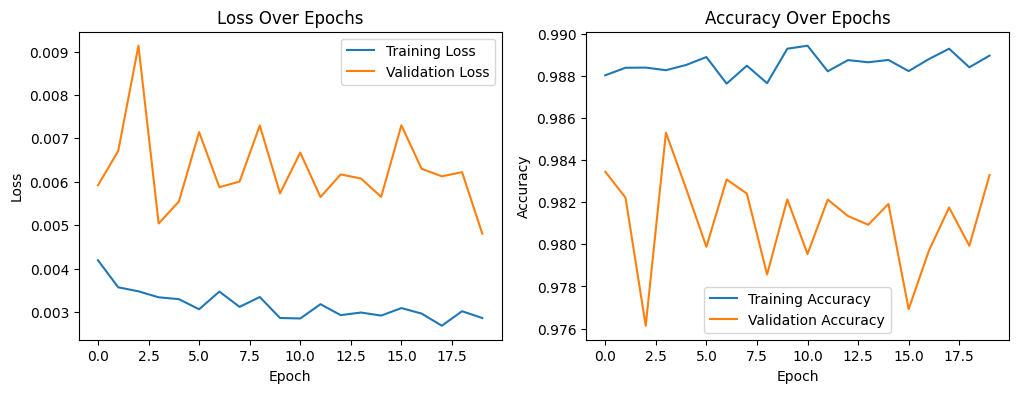

In [164]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call to plot the history
plot_history(history2)

1/1 [==============================] - 0s 21ms/step


[]

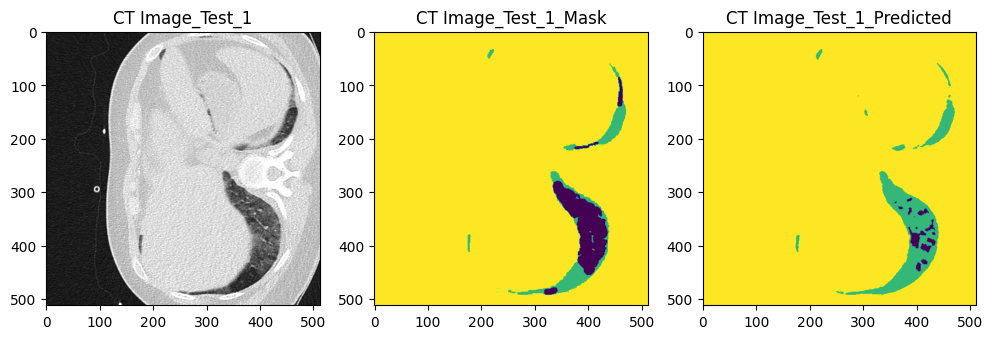

In [176]:
sample_test, sample_mask = next(test_generator)
ig, ax = plt.subplots(1, 3, figsize=(12, 6))
# Plot the mask
ax[0].imshow(sample_test[0], cmap='gray')
ax[0].set_title('CT Image_Test_1')

ax[1].imshow(np.argmax(sample_mask[0],axis=-1), cmap='viridis')
ax[1].set_title('CT Image_Test_1_Mask')

prediction = model.predict(sample_test)

predicted_image = np.argmax(prediction,axis=-1)[0]
#ig, ax = plt.subplots(1, 1, figsize=(12, 6))
# Plot the mask
ax[2].imshow(predicted_image, cmap='viridis')
ax[2].set_title('CT Image_Test_1_Predicted')


# plt.title("Test Mask and Predictions")
plt.plot()

Now We will use this Model to predict different dataset using Transfer Learning 

Renaming the Dataset in the format Image1 to Image N and similarly for the Mask 1 to Mask N 

In [180]:
import os

# Define the directory containing the images and masks
image_dir = 'D:\\Anik\\NewData\\archive\\supervisely_person_clean_2667_img\\supervisely_person_clean_2667_img\\images'
mask_dir = 'D:\\Anik\\NewData\\archive\\supervisely_person_clean_2667_img\\supervisely_person_clean_2667_img\\masks'


# Get the list of image and mask files and sort them to maintain order
image_files = sorted([f for f in os.listdir(image_dir) if not f.startswith('.')])
mask_files = sorted([f for f in os.listdir(mask_dir) if not f.startswith('.')])

# Rename images
for i, filename in enumerate(image_files, 1):
    old_path = os.path.join(image_dir, filename)
    new_path = os.path.join(image_dir, f'image{i}.jpg')  # Change file extension if needed
    os.rename(old_path, new_path)

# Rename masks
for i, filename in enumerate(mask_files, 1):
    old_path = os.path.join(mask_dir, filename)
    new_path = os.path.join(mask_dir, f'mask{i}.jpg')  # Change file extension if needed
    os.rename(old_path, new_path)

print("Renaming complete.")


Renaming complete.


Preprocessing

In [204]:
from PIL import Image
import os


def resize_and_convert_to_grayscale(image_dir, mask_dir, target_size=(512, 512)):
    # Resize and convert images to grayscale
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):  # Ensure this checks for your actual image format
            path = os.path.join(image_dir, filename)
            new_filename = f'grayscale_{filename}'  # Change filename to indicate the transformation
            new_path = os.path.join(image_dir, new_filename)  # Construct the full new path with filename
            img = Image.open(path)
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            img = img.convert('L')
            img.save('D:\\Anik\\NewData\\preprocessedHuman\\images'+new_filename)  # Save with the new path including the file extension

    # Resize and convert masks to grayscale
    for filename in os.listdir(mask_dir):
        if filename.endswith(".jpg"):  # Ensure this checks for your actual mask format
            path = os.path.join(mask_dir, filename)
            new_filename = f'grayscale_{filename}'  # Similarly change mask filename
            new_path = os.path.join(mask_dir, new_filename)  # Construct the new path for masks
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            img.save('D:\\Anik\\NewData\\preprocessedHuman\\masks'+new_filename)


# Specify your directories
image_directory = image_dir
mask_directory = mask_dir

# Call the function
resize_and_convert_to_grayscale(image_directory, mask_directory)


In [258]:
import os

# Absolute path example
img_dir = 'D:\\Anik\\NewData\\train\\preprocessedHuman\\'
mask_dir = 'D:\\Anik\\NewData\\train\\preprocessedHumanMask\\'

# image_dir = os.path.join(base_dir, 'images')
# mask_dir = os.path.join(base_dir, 'masks')


In [265]:
img_dir

'D:\\Anik\\NewData\\train\\preprocessedHuman\\'

In [261]:
img_dir_test = 'D:\\Anik\\NewData\\test\\preprocessedHuman\\'
img_dir_mask = 'D:\\Anik\\NewData\\test\\preprocessedHumanMask\\'

In [240]:
image_dir

'D:\\Anik\\NewData\\preprocessedHuman\\images'

In [242]:
image_generator = image_datagen.flow_from_directory(
    'D:/Anik/NewData/preprocessedHuman/images',  # Assuming your images are color images
    seed=42
)

Found 0 images belonging to 0 classes.


In [274]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming this is the correct base directory path
# Set up the generators
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    img_dir,
    target_size=(512, 512),
    batch_size=2,
    class_mode=None,
    color_mode='grayscale',  # Assuming your images are color images
    seed=42
)

mask_generator = mask_datagen.flow_from_directory(
    mask_dir,
    target_size=(512, 512),
    batch_size=2,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Combine the generators
train_generator = zip(image_generator, mask_generator)

# Verify batch synchronization and quantity
print('Image batches found:', len(image_generator))
print('Mask batches found:', len(mask_generator))


Found 2330 images belonging to 1 classes.
Found 2330 images belonging to 1 classes.
Image batches found: 1165
Mask batches found: 1165


In [260]:
# Setup for the test data
test_image_generator = image_datagen.flow_from_directory(
    img_dir_test,
    target_size=(512, 512),
    batch_size=10,
    class_mode=None,
    color_mode='rgb',
    subset='validation',  # Specify validation subset for testing
    seed=42
)

test_mask_generator = mask_datagen.flow_from_directory(
    img_dir_mask,
    target_size=(512, 512),
    batch_size=10,
    class_mode=None,
    color_mode='grayscale',
    subset='validation',  # Specify validation subset for testing
    seed=42
)

test_generator = zip(test_image_generator, test_mask_generator)

Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [266]:
import tensorflow as tf

class FocalCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name='focal_cross_entropy'):
        super(FocalCrossEntropy, self).__init__(reduction=reduction, name=name)
        self.gamma = gamma
        self.alpha = alpha
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        y_true = tf.cast(y_true, dtype=tf.float32)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = self.alpha * tf.pow(1 - y_pred, self.gamma) * cross_entropy
        return tf.reduce_mean(loss, axis=-1)

    def get_config(self):
        config = super(FocalCrossEntropy, self).get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha,
            "from_logits": self.from_logits
        })
        return config


In [267]:
AttentionUnet = tf.keras.models.load_model(
    '100_Epoch_SGD_AttentionUnetFocalCrossEntropy.h5', 
    custom_objects={
        'FocalCrossEntropy': FocalCrossEntropy,  # Pass the class, not an instance
        'mean_iou': mean_iou  # Assuming mean_iou is a function or a class; do not instantiate if it's a class
    }
)


In [268]:
for layer in AttentionUnet.layers[:-1]:  # Exclude the last layer
    layer.trainable = False


In [282]:
AttentionUnet.layers[-2].output

<KerasTensor: shape=(None, 512, 512, 64) dtype=float32 (created by layer 'activation_39')>

In [283]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

# Remove the last layer
AttentionUnet.layers.pop()

# Add a new Dense layer with 1 unit for binary classification
new_output = L.Conv2D(1, 1,activation='sigmoid')(AttentionUnet.layers[-2].output)

# Create a new model
transferLearningAttentionUnet = Model(inputs=AttentionUnet.inputs, outputs=new_output)


In [290]:
from tensorflow.keras.losses import BinaryFocalCrossentropy
transferLearningAttentionUnet.compile(optimizer=optimize, loss=BinaryFocalCrossentropy(), metrics=['accuracy',mean_iou])


In [291]:
transferLearningAttentionUnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 512, 512, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 512, 512, 64  256        ['conv2d_43[0][0]']              
 ormalization)                  )                                                           

In [306]:
from tensorflow.keras.utils import plot_model

# Generate a plot of the model architecture
plot_model(transferLearningAttentionUnet, to_file='AttentionUnet.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


: 

In [292]:
transferLearningHistory = transferLearningAttentionUnet.fit(train_generator,steps_per_epoch=1165, epochs=15)

Epoch 1/15


1165/1165 [==============================] - 338s 289ms/step - loss: 0.1684 - accuracy: 0.6339 - mean_iou: 0.0819
Epoch 2/15
1165/1165 [==============================] - 260s 224ms/step - loss: 0.1636 - accuracy: 0.6371 - mean_iou: 0.0804
Epoch 3/15
1165/1165 [==============================] - 258s 221ms/step - loss: 0.1626 - accuracy: 0.6423 - mean_iou: 0.0840
Epoch 4/15
1165/1165 [==============================] - 257s 220ms/step - loss: 0.1643 - accuracy: 0.6398 - mean_iou: 0.0906
Epoch 5/15
1165/1165 [==============================] - 256s 220ms/step - loss: 0.1631 - accuracy: 0.6407 - mean_iou: 0.0864
Epoch 6/15
1165/1165 [==============================] - 256s 220ms/step - loss: 0.1620 - accuracy: 0.6462 - mean_iou: 0.0866
Epoch 7/15
1165/1165 [==============================] - 255s 219ms/step - loss: 0.1629 - accuracy: 0.6463 - mean_iou: 0.0961
Epoch 8/15
1165/1165 [==============================] - 257s 220ms/step - loss: 0.1632 - accuracy: 0.6402 - mean_iou: 0.1011
Epoch 9/15


In [295]:
transferLearningAttentionUnet.save("TransferLearningAttentionUnet5epoch.h5") # When loading add custom object mean IoU

ValueError: Unable to synchronously create dataset (name already exists)

In [213]:
# import pandas as pd

# output = pd.DataFrame(
#              data=np.stack((np.arange(len(reduced_predictions.ravel())), 
#                                         reduced_predictions.ravel().astype(int)),
#                                        axis=-1), 
#              columns=['Id', 'Predicted'])\
# .set_index('Id').to_csv('submission.csv')


In [22]:
history1 = model1.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 2,
    validation_data=val_generator,
    validation_steps=len(val_images) // 2,
    epochs=50
)

Epoch 1/50
233/233 [==============================] - 157s 581ms/step - loss: 0.5917 - accuracy: 0.7954 - val_loss: 0.4532 - val_accuracy: 0.8107
Epoch 2/50
233/233 [==============================] - 342s 1s/step - loss: 0.4250 - accuracy: 0.8136 - val_loss: 0.4240 - val_accuracy: 0.8116
Epoch 3/50
233/233 [==============================] - 256s 1s/step - loss: 0.4031 - accuracy: 0.8140 - val_loss: 0.4041 - val_accuracy: 0.8257
Epoch 4/50
233/233 [==============================] - 324s 1s/step - loss: 0.3394 - accuracy: 0.8376 - val_loss: 0.2737 - val_accuracy: 0.9304
Epoch 5/50
233/233 [==============================] - 444s 2s/step - loss: 0.3958 - accuracy: 0.8227 - val_loss: 0.3633 - val_accuracy: 0.8178
Epoch 6/50
233/233 [==============================] - 402s 2s/step - loss: 0.3552 - accuracy: 0.8327 - val_loss: 0.4156 - val_accuracy: 0.7117
Epoch 7/50
233/233 [==============================] - 321s 1s/step - loss: 0.3729 - accuracy: 0.8304 - val_loss: 0.3956 - val_accuracy: 0.7

In [71]:
model1.save('50Epoch_SGD.hd5')

INFO:tensorflow:Assets written to: 50Epoch_SGD.hd5\assets


INFO:tensorflow:Assets written to: 50Epoch_SGD.hd5\assets


In [72]:
history2 = model1.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 2,
    validation_data=val_generator,
    validation_steps=len(val_images) // 2,
    epochs=15
)

Epoch 1/15
233/233 [==============================] - 123s 525ms/step - loss: 0.1163 - accuracy: 0.9619 - val_loss: 0.0964 - val_accuracy: 0.9696
Epoch 2/15
233/233 [==============================] - 318s 1s/step - loss: 0.0956 - accuracy: 0.9676 - val_loss: 0.1368 - val_accuracy: 0.9524
Epoch 3/15
233/233 [==============================] - 451s 2s/step - loss: 0.1115 - accuracy: 0.9648 - val_loss: 0.0865 - val_accuracy: 0.9709
Epoch 4/15
233/233 [==============================] - 514s 2s/step - loss: 0.0859 - accuracy: 0.9714 - val_loss: 0.0900 - val_accuracy: 0.9713
Epoch 5/15
233/233 [==============================] - 411s 2s/step - loss: 0.0747 - accuracy: 0.9750 - val_loss: 0.0755 - val_accuracy: 0.9761
Epoch 6/15
233/233 [==============================] - 511s 2s/step - loss: 0.0682 - accuracy: 0.9774 - val_loss: 0.0926 - val_accuracy: 0.9736
Epoch 7/15
233/233 [==============================] - 536s 2s/step - loss: 0.1176 - accuracy: 0.9625 - val_loss: 0.0956 - val_accuracy: 0.9

In [95]:
model1.save('65Epochs_SGD')

INFO:tensorflow:Assets written to: 65Epochs_SGD\assets


INFO:tensorflow:Assets written to: 65Epochs_SGD\assets


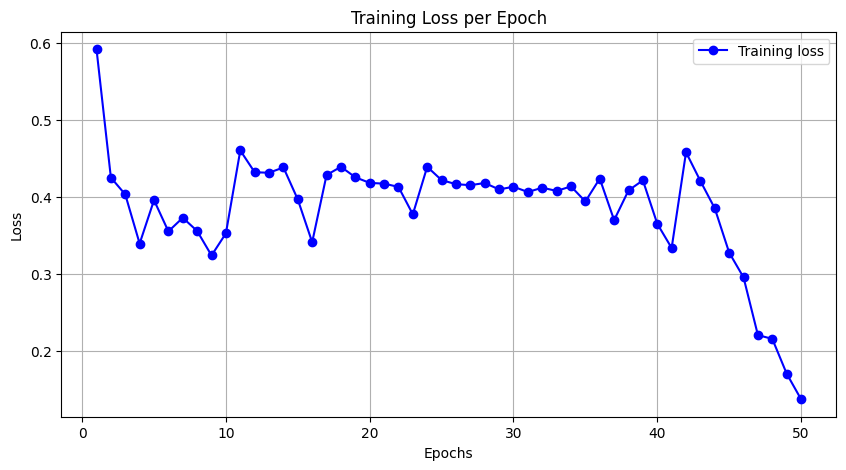

In [23]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned from 'model.fit'
loss = history1.history['loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned from 'model.fit'
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs,val_loss,'ro-',label = 'validation loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'history2' is not defined

In [31]:
test_split_preds = model1.predict(test_generator,steps=50)

50/50 [==============================] - 8s 163ms/step


In [32]:
import numpy as np

# Assuming the predictions are probabilities, convert them to binary format
threshold = 0.5
binary_predictions = (test_split_preds > threshold).astype(np.bool)
true_labels = test_masks

print("Predictions shape:", binary_predictions.shape)
print("Predictions Mask shape:", true_labels.shape)

Predictions shape: (100, 512, 512, 4)
Predictions Mask shape: (100, 512, 512, 4)


c:\Users\Anik\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [35]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 29ms/step


[]

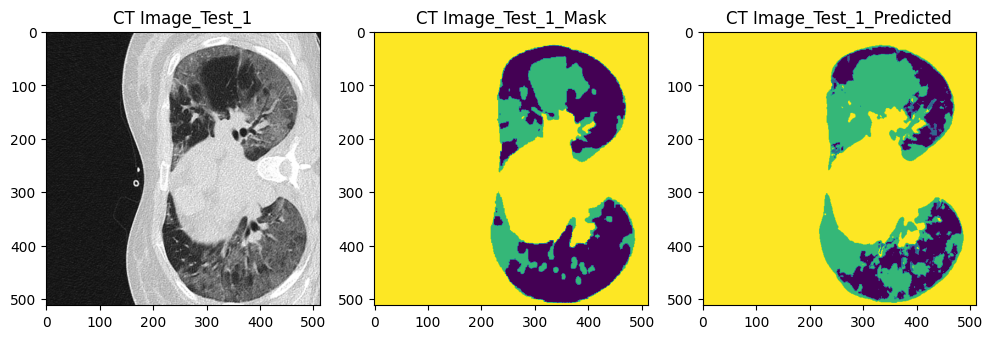

In [48]:
sample_test, sample_mask = next(test_generator)
ig, ax = plt.subplots(1, 3, figsize=(12, 6))
# Plot the mask
ax[0].imshow(sample_test[0], cmap='gray')
ax[0].set_title('CT Image_Test_1')

ax[1].imshow(np.argmax(sample_mask[0],axis=-1), cmap='viridis')
ax[1].set_title('CT Image_Test_1_Mask')

prediction = model1.predict(sample_test)

predicted_image = np.argmax(prediction,axis=-1)[0]
#ig, ax = plt.subplots(1, 1, figsize=(12, 6))
# Plot the mask
ax[2].imshow(predicted_image, cmap='viridis')
ax[2].set_title('CT Image_Test_1_Predicted')


# plt.title("Test Mask and Predictions")
plt.plot()

#prediction = model.predict(sample_test)

In [44]:
def calculate_iou(preds, labels):
    intersection = np.logical_and(preds, labels)
    union = np.logical_or(preds, labels)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_dice(preds, labels):
    intersection = np.logical_and(preds, labels)
    dice = 2 * np.sum(intersection) / (np.sum(preds) + np.sum(labels))
    return dice


In [33]:
iou_scores = []
dice_scores = []

# Iterate over the class dimension
for i in range(binary_predictions.shape[-1]):  # Adjust index for your class dimension
    class_iou = calculate_iou(binary_predictions[:, :, i], true_labels[:, :, i])
    class_dice = calculate_dice(binary_predictions[:, :, i], true_labels[:, :, i])
    iou_scores.append(class_iou)
    dice_scores.append(class_dice)

print("IoU Scores per class:", iou_scores)
print("Dice Scores per class:", dice_scores)


IoU Scores per class: [0.9936468341355992, 0.9996875488204968, 0.9998828193660527, 0.9997656524626021]
Dice Scores per class: [0.9968132942326491, 0.99984375, 0.99994140625, 0.9998828125]


In [2]:
from tensorflow.keras.models import load_model

# Load the model from the SavedModel directory
model1 = load_model('65Epochs_SGD')